In [1]:
# Import Libraries

import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, Linear
import torch.nn.functional as F

In [2]:
df = pd.read_csv("Data/features_3_sec.csv")
class_list = df.iloc[:, -1]
convertor = LabelEncoder() # Label Encoding - encode the categorical classes with numerical integer values for training

# Remove the columns not needed, also label is stored in class_list now so also remove from data
df = df.drop(columns=["filename", "length", "label"])

# Labels will be something like this
# Blues - 0
# Classical - 1
# Country - 2
# Disco - 3
# Hip-hop - 4 
# Jazz - 5  
# Metal - 6 
# Pop - 7
# Reggae - 8
# Rock - 9

# Convert labels to numeric
y = convertor.fit_transform(class_list)
y

array([0, 0, 0, ..., 9, 9, 9])

In [3]:
fit = StandardScaler()
X = fit.fit_transform(df) # Store for later use
X

array([[-0.48780784,  0.64052047, -0.00662408, ..., -0.51356204,
         0.12841417, -0.29178072],
       [-0.40314187,  0.13183473, -0.26494432, ...,  1.01138445,
         1.27578001,  0.05642464],
       [-0.36169428,  0.7644909 ,  0.01669533, ..., -0.04624405,
         0.65390663, -0.52145798],
       ...,
       [-0.35433044,  0.42997426, -1.14464442, ..., -0.15370124,
         0.11765485, -0.33882395],
       [ 0.0883611 , -0.00630133, -0.93999575, ..., -0.72456977,
         0.30333409, -0.95893743],
       [-0.11321002,  0.19536324, -1.17205474, ..., -0.37245283,
        -0.47495901, -0.55112155]])

0.566223462446834
9990
Edge Count:  179820


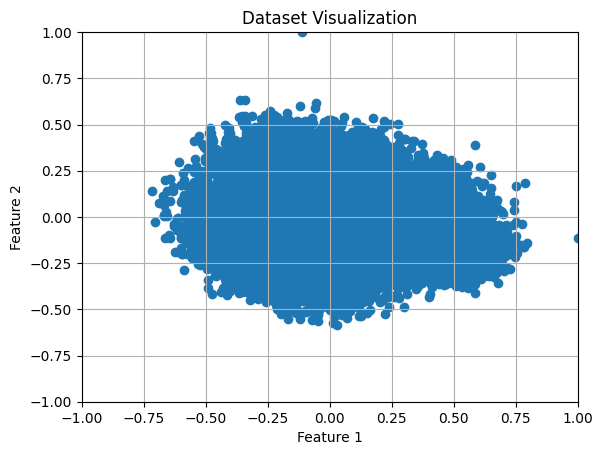

In [4]:
'''
https://ieeexplore.ieee.org/document/9378189

^ Above paper is essentially the intuition for using cosine_similarity here.
The GNN v1 was a 'complete graph', and since our goal is to minimize the number of edges for the graph,
we will just use the cosine similarity to place edges between the most similar features

Additional Resource: https://memgraph.com/blog/cosine-similarity-python-scikit-learn
'''

similarity_matrix = cosine_similarity(X)

# Create k-NN graph
k = 9  # Number of neighbors, use elbow method?
edges = []
for i in range(len(X)):
    # Get indices of k most similar nodes
    neighbors = np.argsort(-similarity_matrix[i])[1:k+1]  # Exclude self, get k neighbors
    # print(len(neighbors))
    for neighbor in neighbors:
        # print("Neighbor: ", neighbor)
        edges.append([i, neighbor])
        edges.append([neighbor, i])  # Add bidirectional edges

# Convert edges to PyTorch tensor
# Idea from: https://github.com/pyg-team/pytorch_geometric/issues/734
# Also from torch_geometric documentation
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

print(similarity_matrix[0][1])
print(len(similarity_matrix[0]))
# np.matrix(similarity_matrix).view()
print("Edge Count: ", len(edges))
plt.scatter(similarity_matrix[5], similarity_matrix[12], marker='o')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title('Dataset Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.show()
# similarity_matrix

In [5]:
# Example matrix
# matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Plot the heatmap
# sns.heatmap(similarity_matrix, annot=True, cmap="coolwarm")
# plt.title('Matrix Heatmap')
# plt.show()

In [6]:
'''
This should give a rough idea of what the graph looks like
Wanted to check number of connected components but DFS hits max recursion depth

Takes a few minutes to run so leave commented out unless needed
'''
# viewG = nx.Graph(edges)
# nx.draw(viewG, with_labels=True)
# plt.show()


'\nThis should give a rough idea of what the graph looks like\nWanted to check number of connected components but DFS hits max recursion depth\n\nTakes a few minutes to run so leave commented out unless needed\n'

In [7]:
'''
Code is learned and modified from GeeksforGeeks article: https://www.geeksforgeeks.org/graph-neural-networks-with-pytorch/
^ The above is used to define the GCN() method, as well as used later to understand and modify the train_gnn() method

Outline as given in BASIRA Lab video '4.5 Generalized GNN layer and Dropout'
    - https://www.youtube.com/watch?v=3e5zjVKsbsw&list=PLug43ldmRSo14Y_vt7S6vanPGh-JpHR7T&index=19

Video provides the structure for what the layers should be, here we use Conv.

Note that for forward, we just return x instead of doing softmax because we are using the CrossEntropyLoss anyways
^ This intuition for this: https://stackoverflow.com/questions/55675345/should-i-use-softmax-as-output-when-using-cross-entropy-loss-in-pytorch

-- Added additional layer 3
'''

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim) # Additional layer

        self.conv3 = GCNConv(hidden_dim, output_dim) # Additional layer
        self.dropout = torch.nn.Dropout(0.4)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)

        # Added Layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        return x # was F.log_softmax(x, dim=1), but this is redundant
    

In [8]:
'''
Understanding of train-test masks and transductive learning for GNN:
- https://www.youtube.com/watch?v=Lrr25EzAgkI

- Lot of content understanding comes from BASIRA Lab on YouTube, from its Deep Graph Learning videos playlist
'''

X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)
print("the length for y: ", len(y))

# Create train-test split
train_idx, test_idx = train_test_split(
    range(len(y)), test_size=0.2, stratify=y, random_state=42
)

# Create masks
train_mask = torch.zeros(len(y), dtype=torch.bool)
print("len train mask: ", len(train_mask))
test_mask = torch.zeros(len(y), dtype=torch.bool)
print("len test mask: ", len(test_mask))
train_mask[train_idx] = True
test_mask[test_idx] = True

# Create data object
data = Data(x=X_tensor, edge_index=edge_index, y=y_tensor)
data.train_mask = train_mask
data.test_mask = test_mask

# Check train/test split is proper
train_count = 0
for i in train_mask:
    if i == False:
        train_count = train_count + 1
print("False values: ", train_count)

test_count = 0
for i in train_mask:
    if i == False:
        test_count = test_count + 1
print("False values: ", test_count)

# Confirm no overlap
for i in range(0, len(test_idx)):
    if train_idx[i] == test_idx[i]:
        print("overlap")


the length for y:  9990
len train mask:  9990
len test mask:  9990
False values:  1998
False values:  1998


In [9]:
# Initialize the model
model = GCN(input_dim=data.num_node_features, hidden_dim=128, output_dim=len(set(y)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [10]:
'''
Training for model.
'''

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Store for evaluation metrics
acc_scores = []
prec_scores = []
recall = []
f1 = []

# Store for visualizations
losses = []
accuracy = []

def train_gnn():
    model.train()

    for epoch in range(1000): # Make 1000 epochs
        optimizer.zero_grad()
        output = model(data.x, data.edge_index)
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

        if(loss.item() > losses[-1]):
            break
        
        test_acc = evaluate()

        # Evaluation
        if epoch % 10 == 0:
            # test_acc = evaluate()
            print(f'Epoch {epoch:03d}, Loss: {loss.item():.4f} Test Acc: {test_acc:.4f}')
        

# Precision/Recall/F1 metrics adapted and modified from https://www.geeksforgeeks.org/how-to-calculate-the-f1-score-and-other-custom-metrics-in-pytorch/

def evaluate():
    model.eval()

    # y_true = []
    # y_pred = []

    with torch.no_grad():
        output = model(data.x, data.edge_index)
        pred = output.argmax(dim=1)

        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()

        correct = pred[data.test_mask] == data.y[data.test_mask]
        acc = int(correct.sum()) / int(data.test_mask.sum())

        acc_scores.append(accuracy_score(y_true, y_pred))
        prec_scores.append(precision_score(y_true, y_pred, average='weighted', zero_division=0)) # zero_division for TP + FP = 0, fixes warning message
        recall.append(recall_score(y_true, y_pred, average='weighted', zero_division=0))
        f1.append(f1_score(y_true, y_pred, average='weighted', zero_division=0))

    return acc

In [11]:
# Train 
gnn = train_gnn()

Epoch 000, Loss: 2.8981 Test Acc: 0.1231
Epoch 010, Loss: 1.7859 Test Acc: 0.4154
Epoch 020, Loss: 1.4584 Test Acc: 0.5090
Epoch 030, Loss: 1.2593 Test Acc: 0.5776
Epoch 040, Loss: 1.1273 Test Acc: 0.6086
Epoch 050, Loss: 1.0303 Test Acc: 0.6411
Epoch 060, Loss: 0.9513 Test Acc: 0.6637
Epoch 070, Loss: 0.8853 Test Acc: 0.6912
Epoch 080, Loss: 0.8292 Test Acc: 0.7042
Epoch 090, Loss: 0.7802 Test Acc: 0.7212
Epoch 100, Loss: 0.7367 Test Acc: 0.7337
Epoch 110, Loss: 0.6977 Test Acc: 0.7452
Epoch 120, Loss: 0.6627 Test Acc: 0.7638
Epoch 130, Loss: 0.6317 Test Acc: 0.7788
Epoch 140, Loss: 0.6039 Test Acc: 0.7848
Epoch 150, Loss: 0.5789 Test Acc: 0.7953
Epoch 160, Loss: 0.5559 Test Acc: 0.8043
Epoch 170, Loss: 0.5350 Test Acc: 0.8103
Epoch 180, Loss: 0.5158 Test Acc: 0.8153
Epoch 190, Loss: 0.4980 Test Acc: 0.8163
Epoch 200, Loss: 0.4813 Test Acc: 0.8198
Epoch 210, Loss: 0.4655 Test Acc: 0.8273
Epoch 220, Loss: 0.4504 Test Acc: 0.8298
Epoch 230, Loss: 0.4361 Test Acc: 0.8313
Epoch 240, Loss:

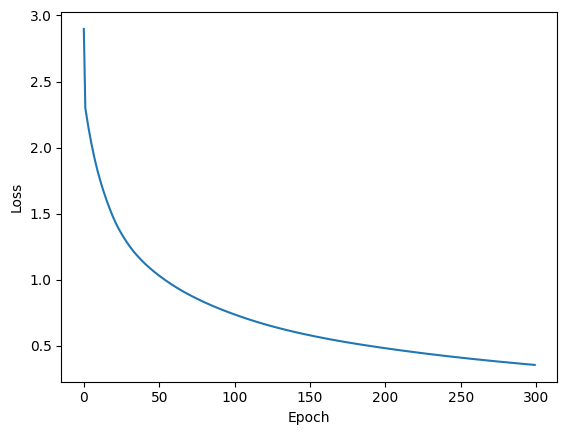

In [12]:
# epoch vs loss plot

epoch = []
for i in range(0, len(losses)):
    epoch.append(i)
epoch[0]

plt.plot(epoch, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

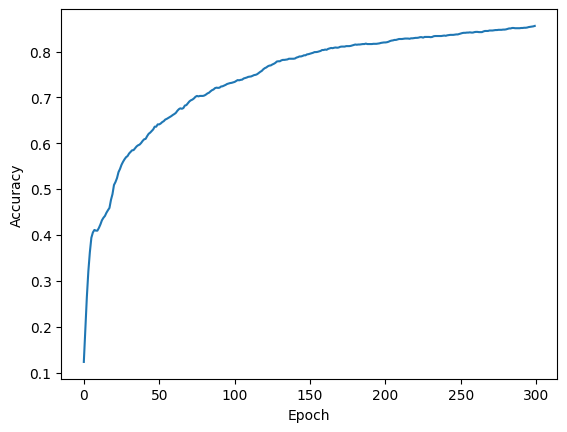

In [13]:
# epoch vs accuracy_scores

plt.plot(epoch, acc_scores)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [14]:
# Metrics

print(f'Accuracy: {acc_scores[-1]:.4f}')
print(f'Precision: {prec_scores[-1]:.4f}')
print(f'Recall: {recall[-1]:.4f}')
print(f'F1 score: {f1[-1]:.4f}')

Accuracy: 0.8559
Precision: 0.8555
Recall: 0.8559
F1 score: 0.8552
